In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers

In [2]:
IMAGE_DIR = Path('./butterflies/train')
DESC_CSV = Path('./butterflies/Training_set.csv')

## Load dataset

In [3]:
desc_df = pd.read_csv(DESC_CSV)
len(desc_df)

6499

In [4]:
desc_df.head()

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

## Plot data

In [5]:
def plot_distribution(class_counts):
    plt.figure(figsize=(10, 8))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Distribution of Butterfly Classes')
    plt.xlabel('Butterfly Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

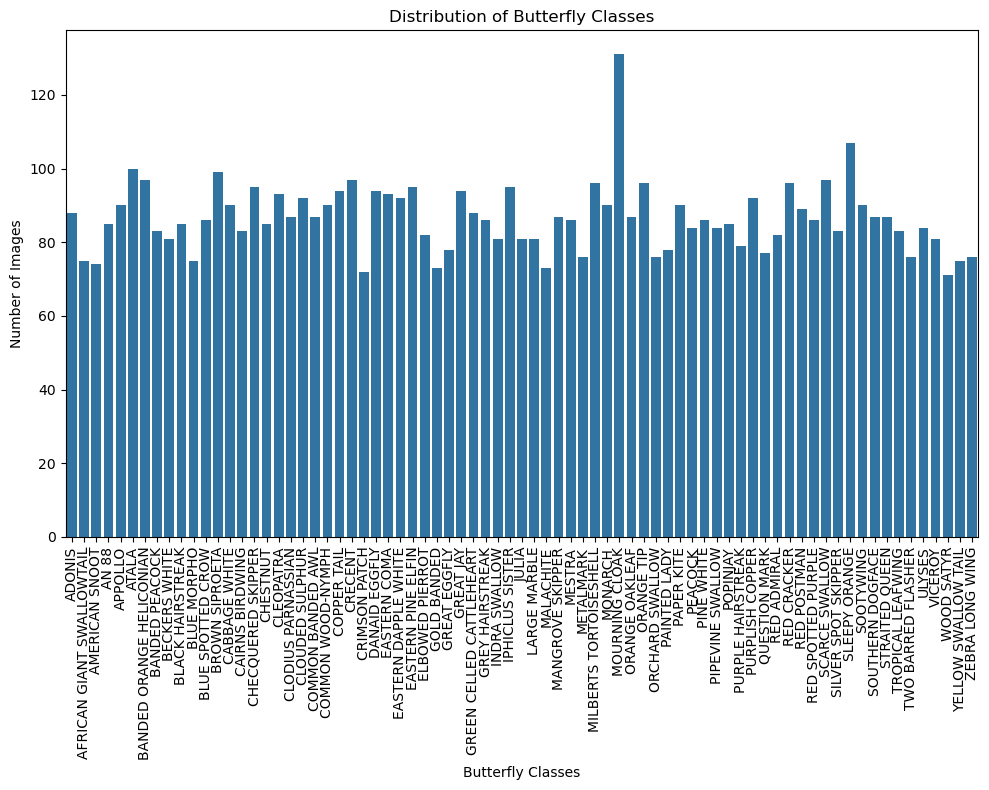

In [6]:
class_counts = desc_df['label'].value_counts().sort_index()
plot_distribution(class_counts)

## Only take a subset of the classes

In [7]:
keep_class_number = 15

top_classes = class_counts.sort_values(ascending=False).head(keep_class_number).index

df_filtered = desc_df[desc_df['label'].isin(top_classes)]

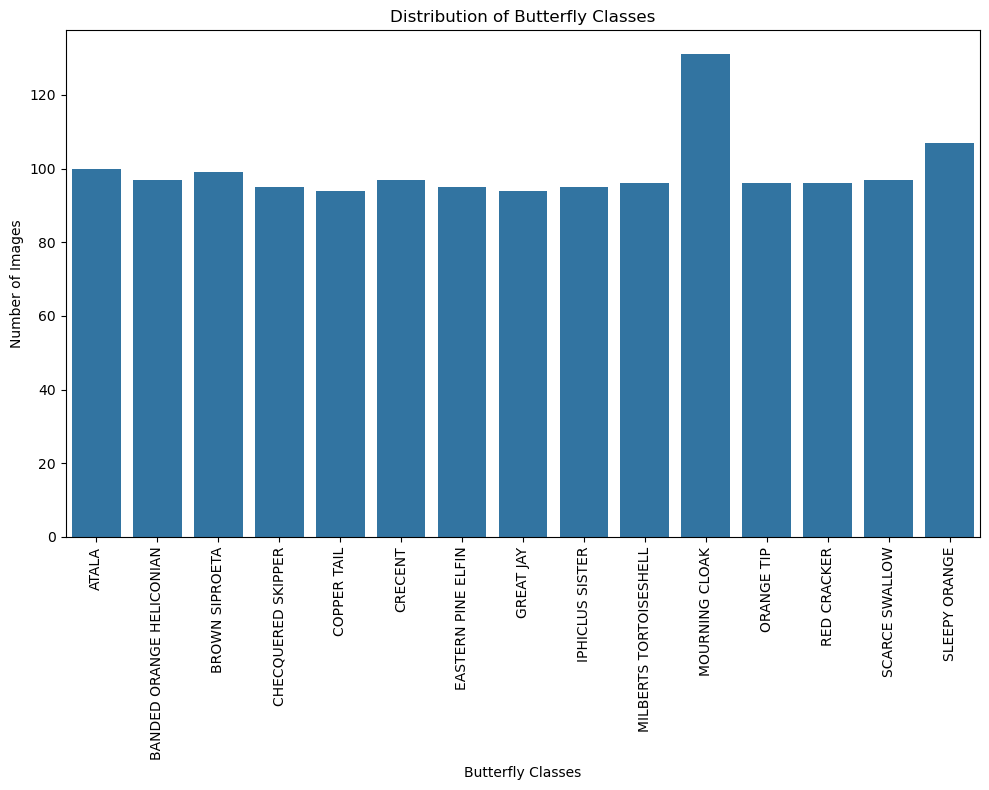

In [8]:
class_counts_f = df_filtered['label'].value_counts().sort_index()
plot_distribution(class_counts_f)

## Undersample to balance the distribution

In [9]:
min_count = df_filtered['label'].value_counts().min()

df_balanced = df_filtered.groupby('label', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42))

df_balanced = df_balanced.reset_index(drop=True)

print(df_balanced['label'].value_counts())

label
ATALA                       94
BANDED ORANGE HELICONIAN    94
BROWN SIPROETA              94
CHECQUERED SKIPPER          94
COPPER TAIL                 94
CRECENT                     94
EASTERN PINE ELFIN          94
GREAT JAY                   94
IPHICLUS SISTER             94
MILBERTS TORTOISESHELL      94
MOURNING CLOAK              94
ORANGE TIP                  94
RED CRACKER                 94
SCARCE SWALLOW              94
SLEEPY ORANGE               94
Name: count, dtype: int64


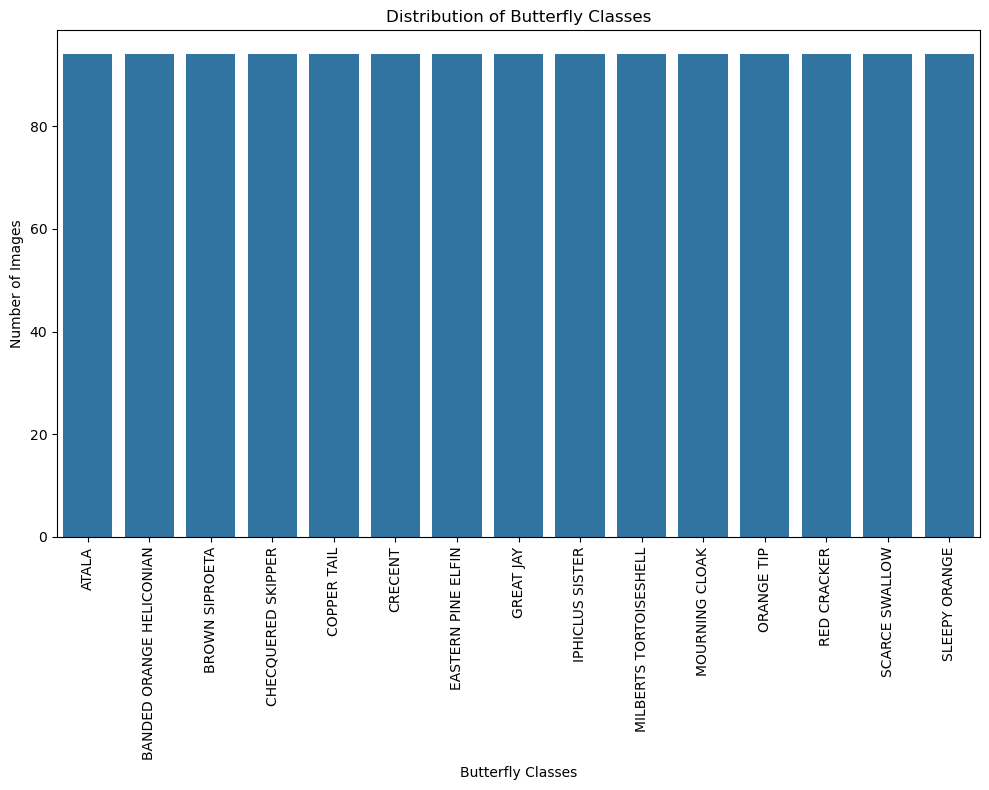

In [10]:
class_counts_b = df_balanced['label'].value_counts().sort_index()
plot_distribution(class_counts_b)

## Show examples

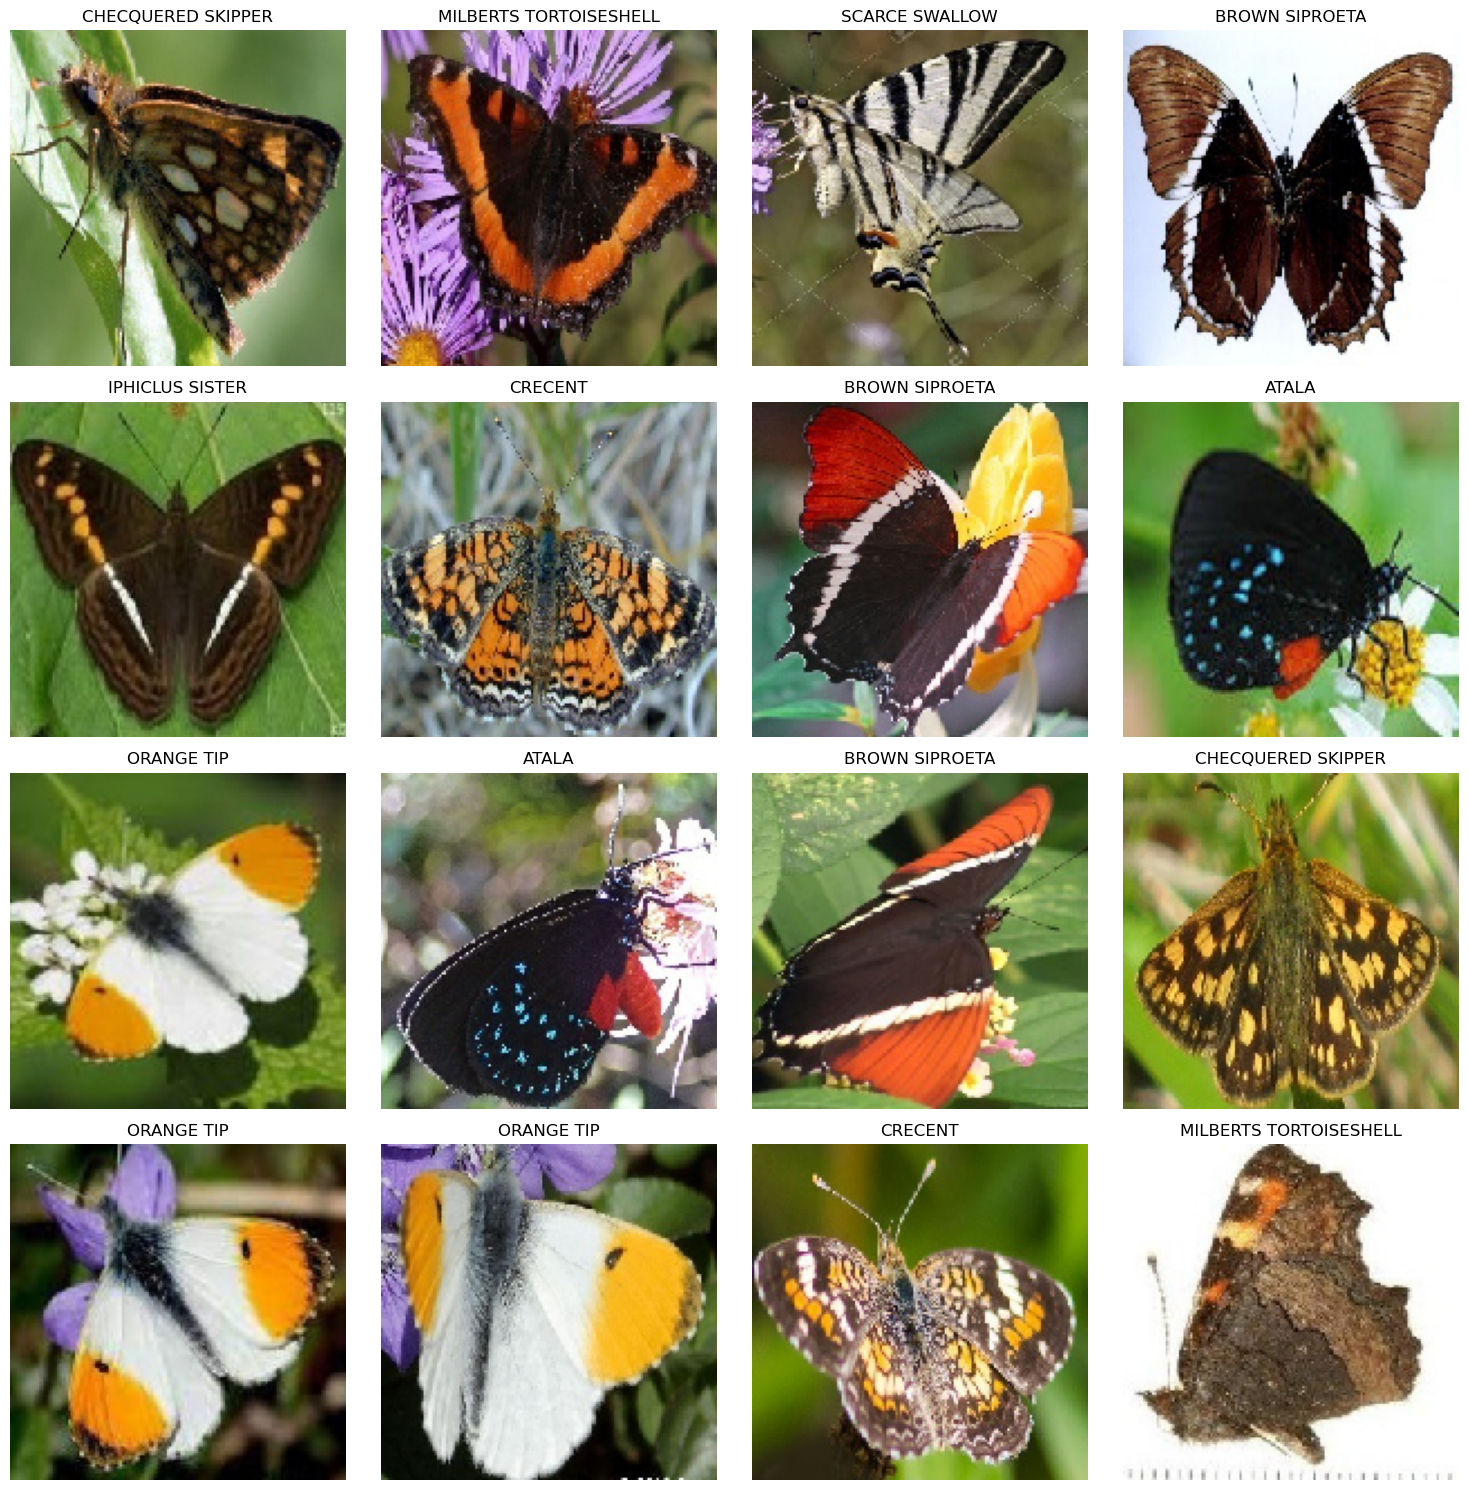

In [11]:
sample_images = df_balanced.sample(16, random_state=42)

fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = IMAGE_DIR / row['filename']
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    
    ax = axes[i // 4, i % 4]
    ax.imshow(img_array)
    ax.set_title(row['label'])
    ax.axis('off')

plt.tight_layout()
plt.show()


## Split to train and test sets

In [12]:
train, test = train_test_split(df_balanced, test_size=0.2, random_state=42)
train.size, test.size

(2256, 564)

## Preprocess images

In [13]:
import tensorflow as tf
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [14]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)

Found 903 validated image filenames belonging to 15 classes.
Found 225 validated image filenames belonging to 15 classes.
Found 282 validated image filenames belonging to 15 classes.


## Pre-trained EfficientNetB0

In [15]:
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [16]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(32, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(32, activation='relu')(x)

outputs = tf.keras.layers.Dense(keep_class_number, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

## Compile model

In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Fit model

In [18]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25
113/113 [==============================] - 29s 210ms/step - loss: 2.0781 - accuracy: 0.3953 - val_loss: 1.4346 - val_accuracy: 0.5867
Epoch 2/25
113/113 [==============================] - 22s 194ms/step - loss: 0.7854 - accuracy: 0.8361 - val_loss: 0.4822 - val_accuracy: 0.9244
Epoch 3/25
113/113 [==============================] - 22s 194ms/step - loss: 0.2924 - accuracy: 0.9446 - val_loss: 0.2709 - val_accuracy: 0.9422
Epoch 4/25
113/113 [==============================] - 22s 195ms/step - loss: 0.1712 - accuracy: 0.9701 - val_loss: 0.2089 - val_accuracy: 0.9378
Epoch 5/25
113/113 [==============================] - 22s 199ms/step - loss: 0.1045 - accuracy: 0.9812 - val_loss: 0.1552 - val_accuracy: 0.9644
Epoch 6/25
113/113 [==============================] - 23s 201ms/step - loss: 0.0739 - accuracy: 0.9889 - val_loss: 0.1832 - val_accuracy: 0.9467
Epoch 7/25
113/113 [==============================] - 22s 195ms/step - loss: 0.0619 - accuracy: 0.9911 - val_loss: 0.1337 - val_ac

## Evaluate model

In [19]:
loss, accuracy = model.evaluate(test_images, verbose=1)
print(f"Test loss: {loss:.2f}")
print("Test accuracy: {:.2f}%".format(accuracy * 100))

36/36 [==============================] - 6s 166ms/step - loss: 0.1075 - accuracy: 0.9645
Test loss: 0.11
Test accuracy: 96.45%


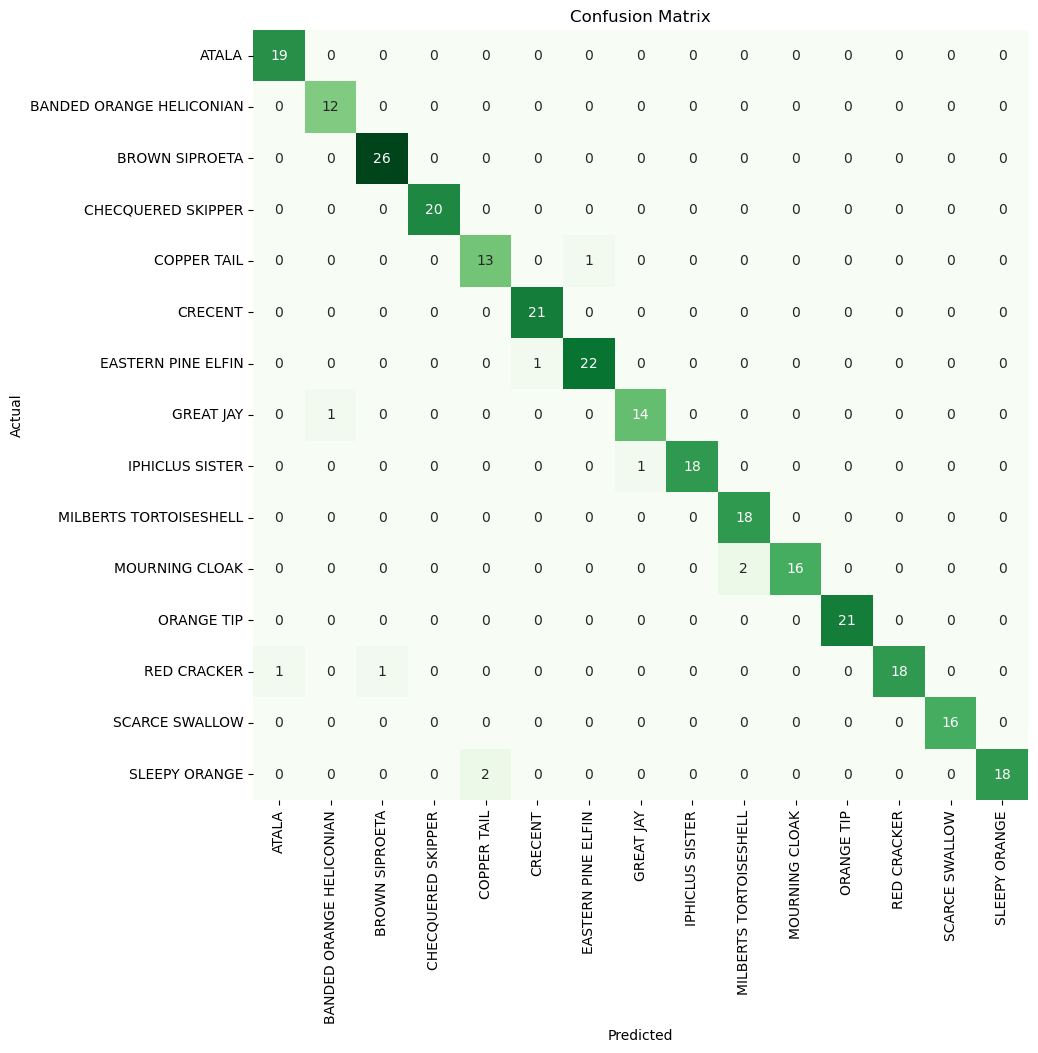

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
plt.xticks(ticks=np.arange(keep_class_number) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(keep_class_number) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                           precision    recall  f1-score   support

                   ATALA       0.95      1.00      0.97        19
BANDED ORANGE HELICONIAN       0.92      1.00      0.96        12
          BROWN SIPROETA       0.96      1.00      0.98        26
      CHECQUERED SKIPPER       1.00      1.00      1.00        20
             COPPER TAIL       0.87      0.93      0.90        14
                 CRECENT       0.95      1.00      0.98        21
      EASTERN PINE ELFIN       0.96      0.96      0.96        23
               GREAT JAY       0.93      0.93      0.93        15
         IPHICLUS SISTER       1.00      0.95      0.97        19
  MILBERTS TORTOISESHELL       0.90      1.00      0.95        18
          MOURNING CLOAK       1.00      0.89      0.94        18
              ORANGE TIP       1.00      1.00      1.00        21
             RED CRACKER       1.00      0.90      0.95        20
          SCARCE SWALLOW    

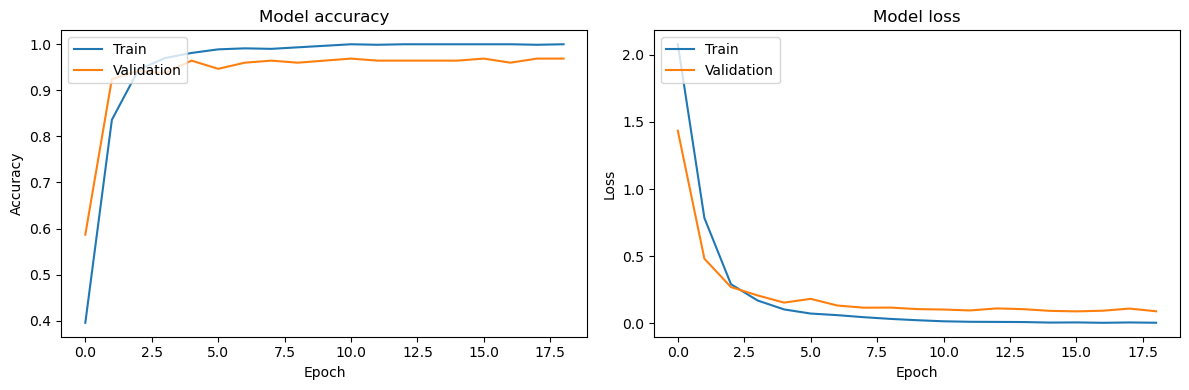

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()